In [1]:
library(ggplot2)
library(ggExtra)
library(brms)
library(reshape2)
library(coda)
library(tidybayes)
library(ggstance)
library(viridis)
library(latex2exp)
library(ggthemes)
library(data.table)
library(bayesplot)
library(fitdistrplus)
library(bda)
library(arules)

Loading required package: Rcpp
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Loading 'brms' package (version 2.9.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').

Attaching package: 'ggstance'

The following objects are masked from 'package:ggplot2':

    geom_errorbarh, GeomErrorbarh

Loading required package: viridisLite

Attaching package: 'data.table'

The following objects are masked from 'package:reshape2':

    dcast, melt

This is bayesplot version 1.7.0
- Online documentation and vignettes at mc-stan.org/bayesplot
- bayesplot theme set to bayesplot::theme_default()
   * Does _not_ affect other ggplot2 plots
   * See ?bayesplot_theme_set for details on theme setting
Loading required package: MASS
Loading required package: survival

Attaching package: 'survival'

The following object is masked from 'package:brms':

    kidney

Loading required 

In [2]:
data_path <- "C:/Users/azgonnikov/Google Drive/data/beyond_reach"
table_path <- "C:/Users/azgonnikov/Dropbox/Research/Journal papers/2019 Beyond reach/tables"

In [3]:
get_k_data <- function(data_path, file_name){
    data <- read.table(file.path(data_path, file_name), header = TRUE, sep = "\t")
    data[, 'subj_id'] <- factor(data[, 'subj_id'])  
    data$AUC <- 1 - data$k

    return(data)
}

In [33]:
get_bf_k <- function(data, var, family, rscale, n=1){   
    # sd(var) in this case is 0.5, as var is task (equal number of 0's and 1's)
    priors_task <- c(set_prior(sprintf('normal(%f, %f)', mean(data[, var]), sd(data[, var])), class='Intercept'),
                    set_prior(sprintf('cauchy(0.0, %f)', rscale*sd(data[, var])/0.5), class='b'))

    formula_null <- as.formula(paste(var, "~ (1 | subj_id)"))
    formula_task <- as.formula(paste(var, "~ (1 | subj_id) + task"))
    formula_session <- as.formula(paste(var, "~ (1 | subj_id) + session"))
    formula_inter <- as.formula(paste(var, "~ (1 | subj_id) + task*session"))

    m_null <- brm(formula_null, data=data, family=family, save_all_pars=TRUE, prior=priors_task[1,],
                  refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))
    m_task <- brm(formula_task, data=data, family=family, save_all_pars=TRUE, prior=priors_task, 
                  refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))    
    m_session <- brm(formula_session, data=data, family=family, save_all_pars=TRUE, prior=priors_task, 
                  refresh=0, control = list(adapt_delta = 0.9, max_treedepth=15))

    bfs <- data.frame(double(), double())
    
    for (i in 1:n) {
        bf <- t(c(bayes_factor(x1=m_task, x2=m_null, silent=TRUE)$bf, 
                  bayes_factor(x1=m_session, x2=m_null, silent=TRUE)$bf))

        bfs <- rbind(bfs, bf)
    }
    colnames(bfs) <- c('bf_task', 'bf_session')
    result = list(bf=colMeans(bfs),  
                  m_null=m_null, 
                  m_task=m_task, 
                  m_session=m_session)    
    return(result)
}

save_posterior <- function(model, file_name){    
    write.csv(as.matrix(as.mcmc(model, combine_chains=TRUE)), 
              file=file.path("posterior_csv", file_name), row.names=FALSE)
}

show_result <- function(result) {
    print("Bayes factors: ")
    print(result$bf)
    hpd_task<-HPDinterval(as.mcmc(result$m_task, combine_chains = TRUE))
    hpd_session<-HPDinterval(as.mcmc(result$m_session, combine_chains = TRUE))
    print("Credible interval for the task effect (walking relative to mouse): ")
    print(hpd_task['b_taskwalking',])
    print("Credible interval for the session effect (2nd session relative to 1st): ")
    print(hpd_session['b_sessionsecond',])
}

# Preregistered analysis

In [5]:
data <- get_k_data(data_path, "k_values.csv")
print(nrow(data))

[1] 108


In [6]:
data

subj_id,task,k,session,sequence,AUC
<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>
1322,mouse,0.9308362,first,mw,0.069163813
1402,mouse,0.9709332,first,mw,0.029066781
1408,mouse,0.3992865,second,wm,0.600713470
1474,mouse,0.8782820,first,mw,0.121718037
1879,mouse,0.8247432,second,wm,0.175256849
2045,mouse,0.7083333,first,mw,0.291666667
2249,mouse,0.9592894,first,mw,0.040710616
2261,mouse,0.8950342,first,mw,0.104965753
2752,mouse,0.9533818,second,wm,0.046618151


Contrary to what was assumed at the time of preregistration, k-values aren't approximated well by the normal distribution. Still, we check Bayes factors according to the originally specified design (`gaussian` family parameter in brms)

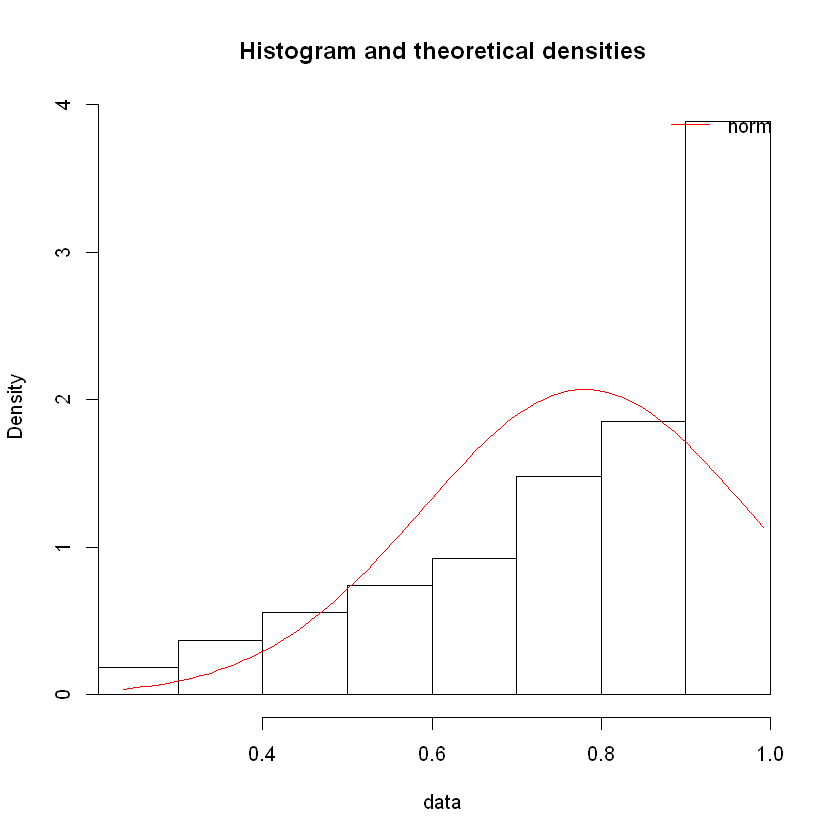

In [7]:
fit_w  <- fitdist(data$k, "norm")
denscomp(fit_w)

In [28]:
prereg_result <- get_bf_k(data, 'k', gaussian(), 0.707, n=10)

[1] "m_null"


Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


[1] "m_task"


Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


[1] "m_session"


Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


[1] "finished fitting the models"
[1] "finished bf calculation"


In [30]:
save_posterior(prereg_result$m_session, "posterior_k_session_prereg.csv")
save_posterior(prereg_result$m_task, "posterior_k_task_prereg.csv")

In [29]:
show_result(prereg_result)

[1] "Bayes factors: "
   bf_task bf_session 
 0.0889623  0.5239769 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.05885114  0.02254180 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
       lower        upper 
-0.078410408 -0.001860316 


# Exploratory analysis

# Accounting for the observed distribution of $k$

After reaching BF>10 in favor of null model over the model with the main effect of task, we terminated data collection, even though BF of the model with the session effect has not yet reached the designated boundary of 10. The reason was that it became evident that there is no difference in discounting behavior between tasks.  Just in case, we checked that this holds if we change the `family` parameter of the brms regression to `weibull`, as Weibull distribution more closely matches the distribution of k-values (we ran the model on zero-peaked quantity `1-k`)

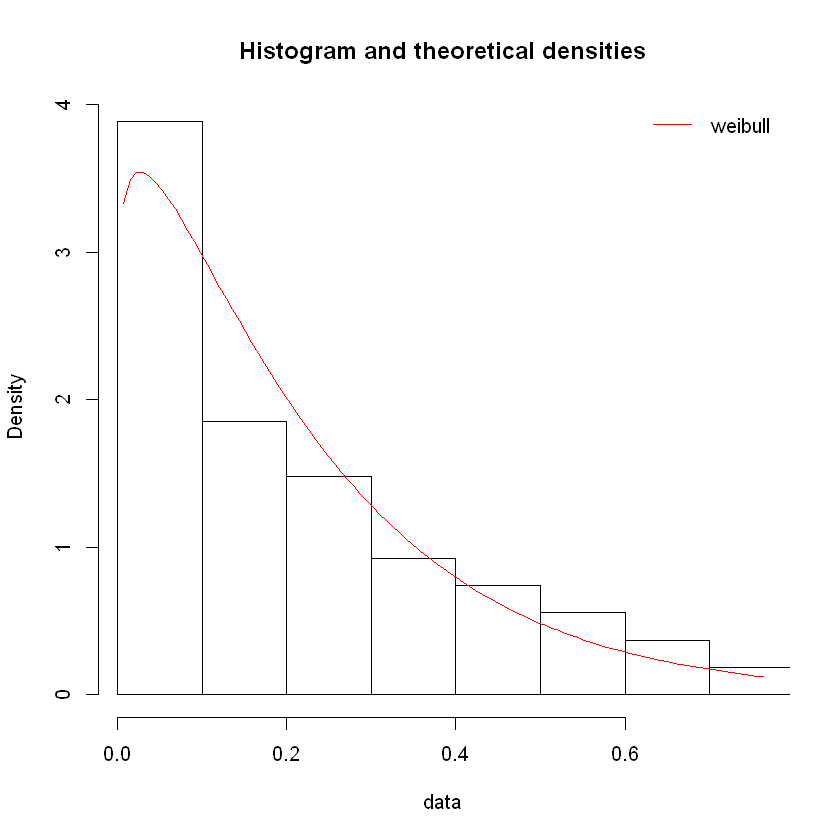

In [8]:
fit_w  <- fitdist(data$AUC, "weibull")
denscomp(fit_w)

In [31]:
AUC_weibull_result <- get_bf_k(data, 'AUC', weibull(), 0.707, n=10)

[1] "m_null"


Compiling the C++ model
Start sampling


[1] "m_task"


Compiling the C++ model
Start sampling


[1] "m_session"


Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


[1] "finished fitting the models"
[1] "finished bf calculation"


In [32]:
show_result(AUC_weibull_result)

[1] "Bayes factors: "
   bf_task bf_session 
 0.3312445  1.3627433 
[1] "Credible interval for the task effect (walking relative to mouse): "
     lower      upper 
-0.1163300  0.2536595 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
      lower       upper 
-0.02854842  0.34495470 


The Bayes factors in favor of the null model decreased and became less conclusive. We however think that using a modified definition of k-value can help to further clarify whether the task or session afffected k. 

# Using log-delays in calculating k-values

Specifically, as many subjects are close to the head part of the k-value distribution (0.9 to 1.0), we might want to emphasize small differences in discounting curves for these subjects. We can do this by changing the definition of k-value in line with Killeen's additive utility model of delay discounting. Specifically, we use log-scaled delays when calculating k-values (which are recorded to \_log.csv files during preprocessing). 

In [13]:
log_delay_data <- get_k_data(data_path, "k_values_log.csv")
print(nrow(log_delay_data))

[1] 108


These k-values are more normally distributed

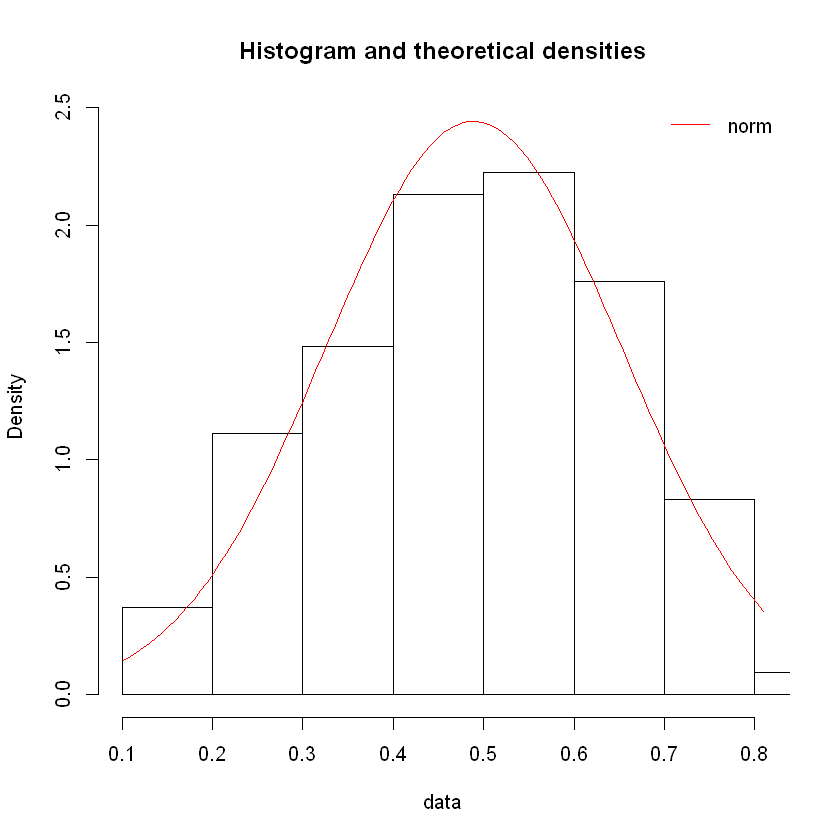

In [14]:
fit_w  <- fitdist(log_delay_data$k, "norm")
denscomp(fit_w)

In [34]:
log_delay_result <- get_bf_k(log_delay_data, 'k', gaussian(), 0.707, n=10)

Compiling the C++ model
recompiling to avoid crashing R session
Start sampling
Compiling the C++ model
Start sampling
Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


In [35]:
save_posterior(log_delay_result$m_session, "posterior_k_session_log_delay.csv")
save_posterior(log_delay_result$m_task, "posterior_k_task_log_delay.csv")

In [36]:
show_result(log_delay_result)

[1] "Bayes factors: "
     bf_task   bf_session 
  0.07994488 532.59584210 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.04522109  0.01913094 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
      lower       upper 
-0.09339020 -0.03714162 


# Saving results to a table

In [24]:
save_bf_table <- function(prereg_result, AUC_weibull_result, log_delay_result, caption, label, file_name){
    hyp_2_format_string <- "\\begin{table}[!htbp]
                \\centering
                \\sisetup{round-mode=places, round-precision=1, scientific-notation=false}
                \\caption{%s}
                \\label{%s}
                \\begin{tabular}{@{}lll@{}}
                \\toprule
                dependent variable & $\\textrm{M}_{\\textrm{task}}$ & $\\textrm{M}_{\\textrm{session}}$ \\\\ \\midrule
                $k \\sim ~ \\textrm{Gaussian}$ & 1/\\num{%g} & 1/\\num{%g}  \\\\
                $k \\sim ~ \\textrm{Weibull}$ & 1/\\num{%g} & 1/\\num{%g}  \\\\
                $k_{\\log} \\sim ~ \\textrm{Gaussian}$ & 1/\\num{%g} & \\num{%g}\\\\ \\bottomrule
                \\end{tabular}
                \\end{table}"
    
    # we invert all BFs < 1 for clarity
    output <- sprintf(hyp_2_format_string, caption, label, 
                      1/prereg_result$bf[1], 1/prereg_result$bf[2], 
                      1/AUC_weibull_result$bf[1], 1/AUC_weibull_result$bf[2], 
                      1/log_delay_result$bf[1], log_delay_result$bf[2])

    fileConn<-file(file.path(table_path, file_name))
    writeLines(output, fileConn)
    close(fileConn)    
}

In [20]:
caption = "Results of testing Hypothesis 2: Bayes factors of the task-only and session-only models 
        over the null model produced by the preregistered analysis ($k \\sim ~ \\textrm{Gaussian}$) and 
        two exploratory analyses"
label = "tab:hyp_2_bf"
file_name = "hyp_2_bf.tex"

save_bf_table(prereg_result, AUC_weibull_result, log_delay_result, caption, label, file_name)

# Checking the effect of rscale

In [11]:
get_all_results <- function(rscale, n=1){
    print("prereg")
    prereg_result <- get_bf_k(data, 'k', gaussian(), rscale, n)
    print("weibull")
    AUC_weibull_result <- get_bf_k(data, 'AUC', weibull(), rscale, n)
    print("log")
    log_delay_result <- get_bf_k(log_delay_data, 'k', gaussian(), rscale, n)
    
    result = list(prereg_result=prereg_result,  
                  AUC_weibull_result=AUC_weibull_result, 
                  log_delay_result=log_delay_result)
    
    return(result)
}

### Narrower priors (rscale = 0.5)

In [15]:
narrow_prior_results <- get_all_results(rscale=0.5, n=10)

[1] "prereg"
[1] "m_null"


Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


[1] "m_task"


Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


[1] "m_session"


Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


[1] "finished fitting the models"
[1] "finished bf calculation"
[1] "weibull"
[1] "m_null"


Compiling the C++ model
Start sampling


[1] "m_task"


Compiling the C++ model
Start sampling


[1] "m_session"


Compiling the C++ model
Start sampling


[1] "finished fitting the models"
[1] "finished bf calculation"
[1] "log"
[1] "m_null"


Compiling the C++ model
Start sampling


[1] "m_task"


Compiling the C++ model
Start sampling


[1] "m_session"


Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


[1] "finished fitting the models"
[1] "finished bf calculation"


In [16]:
show_result(narrow_prior_results$prereg_result)

[1] "Bayes factors: "
   bf_task bf_session 
 0.1169310  0.7083312 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.05823862  0.02250158 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
       lower        upper 
-0.078409791 -0.003380165 


In [17]:
show_result(narrow_prior_results$AUC_weibull_result)

[1] "Bayes factors: "
   bf_task bf_session 
 0.4717402  1.4588452 
[1] "Credible interval for the task effect (walking relative to mouse): "
     lower      upper 
-0.1165975  0.2328673 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
      lower       upper 
-0.03245998  0.33332732 


In [18]:
show_result(narrow_prior_results$log_delay_result)

[1] "Bayes factors: "
    bf_task  bf_session 
  0.1237841 733.0711869 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.04753212  0.01918628 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
      lower       upper 
-0.09352802 -0.03826833 


### Wider priors

In [19]:
wide_prior_results <- get_all_results(rscale=1.0, n=10)

[1] "prereg"
[1] "m_null"


Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


[1] "m_task"


Compiling the C++ model
Start sampling


[1] "m_session"


Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


[1] "finished fitting the models"
[1] "finished bf calculation"
[1] "weibull"
[1] "m_null"


Compiling the C++ model
Start sampling


[1] "m_task"


Compiling the C++ model
Start sampling


[1] "m_session"


Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


[1] "finished fitting the models"
[1] "finished bf calculation"
[1] "log"
[1] "m_null"


Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


[1] "m_task"


Compiling the C++ model
Start sampling


[1] "m_session"


Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


[1] "finished fitting the models"
[1] "finished bf calculation"


In [20]:
show_result(wide_prior_results$prereg_result)

[1] "Bayes factors: "
   bf_task bf_session 
0.07004704 0.42140798 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.05739056  0.02430858 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
       lower        upper 
-0.079767965 -0.001854484 


In [21]:
show_result(wide_prior_results$AUC_weibull_result)

[1] "Bayes factors: "
   bf_task bf_session 
 0.2777884  1.0856647 
[1] "Credible interval for the task effect (walking relative to mouse): "
     lower      upper 
-0.1224638  0.2742162 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
       lower        upper 
-0.006962629  0.368400962 


In [22]:
show_result(wide_prior_results$log_delay_result)

[1] "Bayes factors: "
     bf_task   bf_session 
  0.05838948 363.12468776 
[1] "Credible interval for the task effect (walking relative to mouse): "
      lower       upper 
-0.04551854  0.01857602 
[1] "Credible interval for the session effect (2nd session relative to 1st): "
      lower       upper 
-0.09417449 -0.03959762 


# Saving sensitivity analysis results to separate tables

In [25]:
caption = "Results of testing Hypothesis 2 with narrow priors (scale parameter of the Cauchy distribution set to 1/2): 
        Bayes factors of the task-only and session-only models 
        over the null model produced by the preregistered analysis ($k \\sim ~ \\textrm{Gaussian}$) and 
        two exploratory analyses"
label = "tab:hyp_2_bf_narrow"
file_name = "hyp_2_bf_narrow.tex"

save_bf_table(narrow_prior_results$prereg_result, 
              narrow_prior_results$AUC_weibull_result, 
              narrow_prior_results$log_delay_result, caption, label, file_name)

In [26]:
caption = "Results of testing Hypothesis 2 with wide priors (scale parameter of the Cauchy distribution set to 1): 
        Bayes factors of the task-only and session-only models 
        over the null model produced by the preregistered analysis ($k \\sim ~ \\textrm{Gaussian}$) and 
        two exploratory analyses"
label = "tab:hyp_2_bf_wide"
file_name = "hyp_2_bf_wide.tex"

save_bf_table(wide_prior_results$prereg_result, 
              wide_prior_results$AUC_weibull_result, 
              wide_prior_results$log_delay_result, caption, label, file_name)

# Saving everything to RData file

In [ ]:
save.image()